In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+47.g7f2fb8c32.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.11 GB available memory.


In [4]:
from extra_objectives import CoilBounds, SurfaceMatch

# About this Notebook

We will optimize an umbilic coil for HBT hybrid design.

In [25]:
eq = load("eq_final2.h5")
base_coils = load("hbt_default_coils.h5")  # this is a MixedCoilSet
spline_field = load("hbt_default_coils_spline.h5")  # this is a SplineMagneticField 

use_spline = True
field = base_coils if not use_spline else spline_field

In [38]:
minor_radius = eq.compute("a")["a"]
offset = 1.8 * minor_radius
zeta = np.linspace(0, 2 * np.pi, 41)
helical_offset = 0
R0 = 1.0
# assumes that theta = zeta - helical_offset for n/m=1 umbilic coil
# use m * theta - n * zeta = - helical_offset for general n/m
# parametrization of a curve is R = R0 + offset * cos(theta)
# and Z = offset * sin(theta)
R = R0 + offset * np.cos(zeta - helical_offset)
Z = offset * np.sin(zeta - helical_offset)

data = jnp.vstack([R, zeta, Z]).T
umbilic_coil = FourierRZCoil.from_values(
    current=-2.1e3,
    coords=data,
    N=10,
    basis="rpz",
)
coil_grid = LinearGrid(N=50)
curv_grid = Grid(
    nodes=jnp.concatenate(
        [
            jnp.ones(100),
            jnp.linspace(0, 2 * jnp.pi, 100, endpoint=False),
            jnp.linspace(0, 2 * jnp.pi, 100, endpoint=False),
        ]
    ),
    NFP=1,
    sort=False,
    weights=jnp.ones(100),
)
qa_grid = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)

In [27]:
fig = plot_coils(umbilic_coil)
plot_3d(eq, "|B|", fig=fig)

## Combined Field

In [28]:
if use_spline:
    field = [field, umbilic_coil]
else:
    field = base_coils.copy() 
    field.append(umbilic_coil)

## Constraints

In [29]:
if not use_spline:
    params_to_fix_field = [
        # tf coilset
        {"current": True, "r_n": True, "center": True, "normal": True},
        # vf inner coilset
        {"current": True, "r_n": True, "center": True, "normal": True},
        # vf outer coilset
        {"current": True, "r_n": True, "center": True, "normal": True},
        # oh inner coilset
        {"current": True, "r_n": True, "center": True, "normal": True},
        # oh outer coilset
        {"current": True, "r_n": True, "center": True, "normal": True},
        # umbilic coil
        {"current": False, "R_n": False, "Z_n": False, "rotmat": False, "shift": False},
    ]    

In [30]:
k = 1

modes_R = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]

constraints = (
    ForceBalance(eq=eq),
    FixBoundaryR(eq=eq, modes=modes_R),
    FixBoundaryZ(eq=eq, modes=modes_Z),
    FixPsi(eq=eq),
    FixPressure(eq=eq),
)
if not use_spline:
    # only umbilic coil is has free parameters
    constraints += (
        FixParameters(
            field,
            params_to_fix_field,
        ),
    )
else:
    # fix everything related to the fixed coils
    constraints += (
        FixParameters(field[0]),  # SplineMagneticField
    )
    
if eq.current is not None:
    constraints += (FixCurrent(eq=eq),)
else:
    constraints += (FixIota(eq=eq),)

# build constraints to check broadcasting
for con in constraints:
    con.build()

Precomputing transforms


## Objectives



In [ ]:
len1 = 2 * np.pi * 1.45
len2 = 2 * np.pi * 1.05

dist1 = np.inf
dist2 = 0.1
coils = field if not use_spline else field[1]
weights = {
    "fb": 60,
    "length": 5,
    "min_d": 500,
    "c-bounds": 10,
    "curv": 10,
    "qa": 20,
}
objective = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field,  # in case of spline field, this will internally create a SumMagneticField
            deriv_mode="fwd",
            weight=weights["fb"],
            field_fixed=False,
            bs_chunk_size=10,
            B_plasma_chunk_size=10,
        ),
        CoilLength(
            coils,
            bounds=(0, len2),
            normalize_target=True,
            weight=(
                [0, 0, 0, 0, 0, weights["length"]]
                if not use_spline
                else weights["length"]
            ),
            grid=coil_grid,
            deriv_mode="fwd",
        ),
        PlasmaCoilSetMinDistance(
            eq,
            coils,
            bounds=(0.04, np.inf),
            normalize_target=True,
            coil_grid=coil_grid,
            eq_fixed=True,
            weight=weights["min_d"],
        ),
        CoilBounds(
            coils,
            Rmaj=1.0,
            rmin=0.25,
            target=0,
            normalize_target=True,
            grid=coil_grid,
            weight=(
                [0, 0, 0, 0, 0, weights["c-bounds"]]
                if not use_spline
                else weights["c-bounds"]
            ),
        ),
        GenericObjective(
            "curvature_k2_rho",
            eq,
            grid=curv_grid,
            bounds=(-50, -10),
            weight=weights["curv"],
        ),
        QuasisymmetryTwoTerm(
            eq=eq, helicity=(1, eq.NFP), grid=qa_grid, weight=weights["qa"]
        ),
    ),
    deriv_mode="batched",
)

optimizer = Optimizer("proximal-lsq-exact")

## Optimize

In [40]:
kwargs = {
    "objective": objective,
    "constraints": constraints,
    "verbose": 3,
    "options": {},
    "copy": True,
    "ftol": 1e-10,
    "xtol": 1e-10,
    "gtol": 1e-10,
    "maxiter": 10,
    "x_scale": "ess",
}
if not use_spline:
    [eq, field_opt], out = optimizer.optimize([eq, field], **kwargs)
else:
    [eq, spline_field, umbilic_opt], out = optimizer.optimize(
        [eq, field[0], field[1]], **kwargs
    )

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 38.5 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 4.99 ms
Building objective: plasma-coil minimum distance
Building objective: coil bound
Precomputing transforms
Timer: Precomputing transforms = 3.24 ms
Building objective: Generic
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 762 ms
Timer: Objective build = 1.13 sec
Timer: Objective build = 2.27 ms
Timer: Objective build = 1.91 ms
Timer: Eq Update LinearConstraintProjection build = 2.07 sec
Timer: Proximal projection build = 47.3 sec
Building objective: fixed shift
Building objective: fixed rotation
Timer: Objective build = 23.0 ms
Timer: LinearConstraintProjection build = 1.31 sec
Number of parameters: 51
Number of objectives: 11560
Timer: Initializing the optimization = 48.7 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
-----

In [41]:
if use_spline:
    fig = plot_coils(umbilic_opt)
else:
    fig = plot_coils(field_opt.coils[-1])
plot_3d(eq, "|B|", fig=fig)

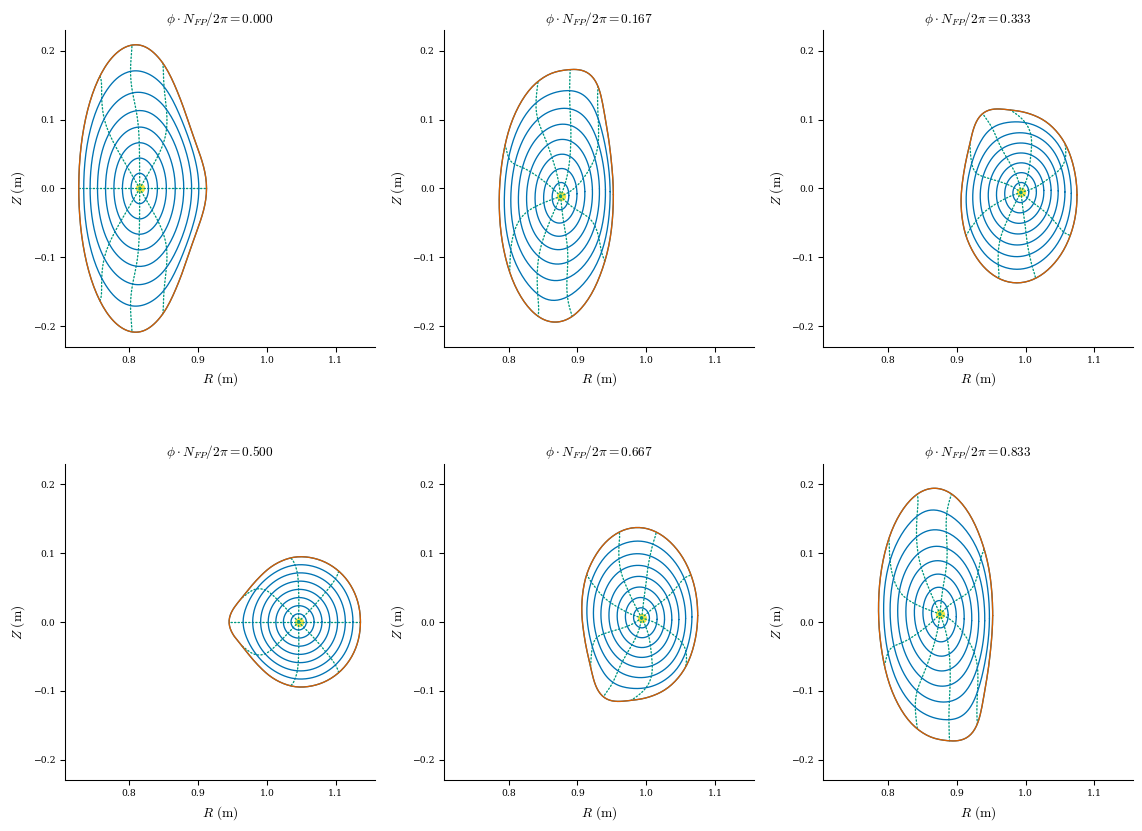

In [43]:
plot_surfaces(eq);